In [14]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

from qat.qpus import get_default_qpu
from qat.core import Batch, Job

from qat.fermion.transforms import transform_to_jw_basis
from qat.fermion.hamiltonians import make_embedded_model
from qat.fermion.circuits import make_shallow_circ, make_ldca_circ

from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation
from qat.fermion.chemistry import MolecularHamiltonian, MoleculeInfo
from qat.fermion.trotterisation import make_trotterisation_routine
from qat.fermion.chemistry.ucc import construct_ucc_ansatz, guess_init_params, get_hf_ket, get_cluster_ops
from qat.qpus import get_default_qpu

from qat.plugins import ScipyMinimizePlugin, MultipleLaunchesAnalyzer

In [15]:
from openvqe.common_files import molecule_factory

In [16]:
import numpy as np
from qat.core import Observable, Term
import numpy as np
import scipy
from numpy import binary_repr
from qat.fermion import ElectronicStructureHamiltonian
from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation

from qat.lang.AQASM import Program, QRoutine, RY, CNOT, RX, Z, H, RZ, I, X
from qat.core import Observable, Term, Circuit
from qat.lang.AQASM.gates import Gate
import matplotlib as mpl
import numpy as np
from typing import Optional, List
import warnings


def ising(N):
    np.random.seed(123)  

    terms = []

    # Generate random coefficients for the transverse field term (X)
    a_coefficients = np.random.random(N)
    for i in range(N):
        term = Term(coefficient=a_coefficients[i], pauli_op="X", qbits=[i])
        terms.append(term)

    # Generate random coefficients for the interaction term (ZZ)
    J_coefficients = np.random.random((N, N))
    for i in range(N):
        for j in range(i):
            if i != j:  # avoid duplicate terms
                term = Term(coefficient=J_coefficients[i, j], pauli_op="ZZ", qbits=[i, j])
                terms.append(term)
    ising = Observable(N, pauli_terms=terms, constant_coeff=0.0)
    return ising


def Molecule_Generator(model):
    if model == "H2":
        r = 0.98
        geometry = [("H", (0, 0, 0)), ("H", (0, 0, r))]
        charge = 0
        spin = 0
        basis = "sto-3g"
    
    elif model == "H4":
        r = 0.85
        geometry = [
            ("H", (0, 0, 0)),
            ("H", (0, 0, 1 * r)),
            ("H", (0, 0, 2 * r)),
            ("H", (0, 0, 3 * r)),
        ]
        charge = 0
        spin = 0
        basis = "sto-3g"
  
    return r, geometry, charge, spin, basis

# Define the the curcuit that we want to use


def circuit_ansatz(nqbits,k, depth, theta_list):
    
    """Returns hardware efficient ansatz circuit.

    Args:
        n_qubit (:class:`int`):
            the number of qubit used (equivalent to the number of fermionic modes)
        depth (:class:`int`):
            depth of the circuit.
        theta_list (:class:`numpy.ndarray`):
            rotation angles.
    Returns:
        :circuit`
    """
    prog = Program()
    reg = prog.qalloc(nqbits)

    state = binary_repr(k)
    state_pad = state.zfill(nqbits)
    state_lst = [int(c) for c in state_pad]


    for j in range(min(nqbits, len(state_lst))):
        if int(state_lst[j] == 1):
            prog.apply(X, reg[j])
        
        if int(state_lst[j] == 0):
            prog.apply(I, reg[j])
    
    print("This applied state is ", state_pad)

    prog.apply(RY(theta_list[-2]), reg[0])
    prog.apply(RZ(theta_list[-1]), reg[0])

    for d in range(depth):
        
        for i in range(nqbits):
            prog.apply(RY(theta_list[2*i+2*nqbits*d]), reg[i])
            prog.apply(RZ(theta_list[2*i+1+2*nqbits*d]), reg[i])
        
        for i in range(nqbits//2):
            prog.apply(CNOT, reg[2*i+1], reg[2*i])
        
        for i in range(nqbits//2-1):
            prog.apply(CNOT, reg[2*i+2], reg[2*i+1])

    for i in range(nqbits):
        prog.apply(RY(theta_list[2*i+2*nqbits*depth]), reg[i])
        prog.apply(RZ(theta_list[2*i+1+2*nqbits*depth]), reg[i])

    return prog.to_circ()



method = "BFGS"


def opt_funct(circuits, model, qpu, nqbits, energy_lists, weight):
    def input_funct(x):
        total_energy = 0
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            result = qpu.submit(bound_circ.to_job(observable=model))
            energy = result.value
            energy_lists[f"energy_circ_{i}"][method].append(energy)
            total_energy += weight[i]*energy
        return total_energy

    def callback(x):
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            result = qpu.submit(bound_circ.to_job(observable=model))
            energy = result.value
            energy_lists[f"energy_circ_{i}"][method].append(energy)

    return input_funct, callback

In [17]:
name = Molecule_Generator("H2")

In [18]:
r, geometry, charge, spin, basis = name
(
    rdm1,
    orbital_energies,
    nuclear_repulsion,
    n_elec,
    one_body_integrals,
    two_body_integrals,
    info,
) = perform_pyscf_computation(
    geometry=geometry, basis=basis, spin=spin, charge=charge, run_fci=True
)
print("Number of electrons = ", n_elec)
nqbits = rdm1.shape[0] * 2
print("Number of qubits before active space selection = ", nqbits)
# print("rdm1", rdm1)
# print(info)
print("Orbital energies = ", orbital_energies)
print("Nuclear repulsion = ", nuclear_repulsion)

Number of electrons =  2
Number of qubits before active space selection =  4
Orbital energies =  [-0.4908283   0.47080536]
Nuclear repulsion =  0.5399767458367347


In [19]:
from qat.fermion.chemistry import MolecularHamiltonian, MoleculeInfo
from qat.fermion.transforms import transform_to_jw_basis

mol_h = MolecularHamiltonian(one_body_integrals, two_body_integrals, nuclear_repulsion)
H = mol_h.get_electronic_hamiltonian()

model = transform_to_jw_basis(H)
print(model)

(-0.3153879047306385+0j) * I^4 +
(0.1574918558293463+0j) * (ZZ|[0, 1]) +
(0.10729348765520527+0j) * (ZZ|[0, 2]) +
(0.15617538348132443+0j) * (ZZ|[1, 2]) +
(0.15617538348132443+0j) * (ZZ|[0, 3]) +
(0.13943713589673468+0j) * (Z|[0]) +
(0.10729348765520527+0j) * (ZZ|[1, 3]) +
(0.1394371358967347+0j) * (Z|[1]) +
(0.048881895826119175+0j) * (XYYX|[0, 1, 2, 3]) +
(-0.048881895826119175+0j) * (XXYY|[0, 1, 2, 3]) +
(-0.048881895826119175+0j) * (YYXX|[0, 1, 2, 3]) +
(0.048881895826119175+0j) * (YXXY|[0, 1, 2, 3]) +
(0.16407160243062638+0j) * (ZZ|[2, 3]) +
(-0.13600541087956414+0j) * (Z|[2]) +
(-0.13600541087956414+0j) * (Z|[3])


In [20]:
print("This model has the number of qubit:", model.nbqbits)
model_matrix_sp = model.get_matrix(sparse=True)
from scipy.sparse.linalg import eigsh
eigenvalues, eigenvectors = eigsh(model.get_matrix(),k=13)
print(eigenvalues)
print(eigenvectors)


This model has the number of qubit: 4
[-1.10531794  0.53997675  0.52624985 -0.60084192 -0.58081898 -0.34365999
  0.06379356 -0.58081898 -0.60084192 -0.04309338 -0.73471515 -0.73471515
 -0.73471515]
[[-3.80695829e-16+9.99421367e-17j  9.62532251e-01-2.71167227e-01j
  -1.14598493e-15+2.79749130e-16j -2.49742304e-16+5.56470001e-17j
  -1.14786561e-16+2.29312184e-17j  1.00879445e-16-2.52448572e-17j
  -2.72850479e-16+8.67032328e-17j -3.05835937e-18+1.51524384e-18j
  -3.00313837e-17+8.08741523e-18j -1.07528624e-16-5.83699974e-17j
   9.58325161e-17-6.20885957e-17j  4.07061911e-18-6.14165782e-18j
  -3.35833831e-18-1.81799137e-17j]
 [ 1.67968113e-16-7.11596178e-18j  2.62957252e-16-2.93718723e-17j
  -9.88256645e-17+3.93174955e-17j -1.21932612e-16+1.44628101e-17j
  -1.89131300e-16+2.46475467e-17j -2.24488520e-16+1.41991094e-17j
   9.35606308e-17+9.47122896e-18j -1.48567494e-16-8.12032718e-18j
  -3.16636980e-17+2.31770786e-17j  4.57749120e-01+5.60345117e-01j
   8.97405457e-17-1.10832811e-16j  1.8783

In [21]:
# Assuming eigenvalues and eigenvectors are obtained
num_eigenvalues = len(eigenvalues)
eigenvec_dict = {}

# I make a loop through each eigenvalue and store its eigenvector
for i in range(num_eigenvalues):
    eigenvector_key = f'ee{i}'
    eigenvector_value = eigenvectors[:, i]
    eigenvec_dict[eigenvector_key] = eigenvector_value

# Now eigenvecToT will be a list containing all eigenvectors
eigenvecToT_tar = [eigenvec_dict[f'ee{i}'] for i in range(num_eigenvalues)]

In [22]:
eigenvecToT = [eigenvecToT_tar[0], eigenvecToT_tar[12]]
print(eigenvecToT)

[array([-3.80695829e-16+9.99421367e-17j,  1.67968113e-16-7.11596178e-18j,
        4.36152940e-19+3.28842706e-17j,  1.33726284e-01-1.04486788e-01j,
       -1.45066205e-16-3.66437512e-16j, -1.47960359e-16-2.22537249e-16j,
       -3.11820866e-16-4.36478507e-16j,  1.12252522e-16-5.49159515e-17j,
        1.71748460e-16+7.66268373e-17j, -1.80591571e-16-8.32535100e-17j,
        4.48970743e-17-2.18335885e-16j, -9.14552359e-17+1.16449193e-17j,
       -7.76556849e-01+6.06761281e-01j,  1.22891477e-16-1.14770708e-16j,
        4.07289455e-16+4.16283258e-16j, -1.29953419e-16-9.43640978e-17j]), array([-3.35833831e-18-1.81799137e-17j, -1.03649803e-17-2.64670117e-17j,
       -2.45564276e-17+4.90276413e-17j, -6.25021981e-18-9.53336693e-19j,
       -1.01887549e-16+5.37683869e-17j,  5.73697430e-01-7.10001052e-01j,
       -1.14797643e-01+2.49036370e-01j, -1.59570937e-16-8.75151500e-17j,
        1.65507968e-17+9.05848667e-17j, -1.14797643e-01+2.49036370e-01j,
        1.21798652e-01-3.92381036e-02j, -3.91177

In [23]:
from qat.lang.AQASM import Program, QRoutine, RY, CNOT, RX, Z, H, RZ, I
from qat.core import Observable, Term, Circuit
from qat.lang.AQASM.gates import Gate
import matplotlib as mpl
import numpy as np
from typing import Optional, List
import warnings

In [24]:
import numpy as np

nqbits = 4
depth = 4

# Introducing the list of excitations that the user can input has to be equal to eigsh(model.get_matrix(),k=6)
k_lst = [0, 1]
prog = Program()
init_theta_list = np.random.random(2 * nqbits * (depth + 1) + 2) * 1e-1  # Imported as it is on the SSVQE qulacs
theta = [prog.new_var(float, rf"\theta_{{{i}}}") for i in range(len(init_theta_list))]

# Define a function to create and display a circuit
def create_circuit(k):
    return circuit_ansatz(4, k, 4, theta)

# Create and store circuits in a list
circuits_store = [create_circuit(k) for k in k_lst]

# Display the circuits
for circ_dis in circuits_store:
    circ_dis.display()

# define weight: # the number of the weight has to be the same as the k_lst
weight = [5,1]
#TEST 
"""
THIS IS FOR k up there eigenvalues, eigenvectors = eigsh(model.get_matrix(),k=5)

1 : 0001
2 : 0010 2.2097726002093622e-14
3 : 1.1798364677136581e-12
4: 1.7220358674238234e-13
5   0101: 5.797517875044644e-14
6   0110: 4.782762177325278e-14
7   0111: 1.2377478734442258e-14
8   1000: 7.581486989342203e-14
9   1001: 2.7724225797035688e-14
10  1010: 5.2141618945739375e-12
11   1011: 3.625621893013965e-10
12   1100: 1.114458919826477e-15
13   1101: 7.65660585019008e-14







"""

This applied state is  0000
This applied state is  0001


'\nTHIS IS FOR k up there eigenvalues, eigenvectors = eigsh(model.get_matrix(),k=5)\n\n1 : 0001\n2 : 0010 2.2097726002093622e-14\n3 : 1.1798364677136581e-12\n4: 1.7220358674238234e-13\n5   0101: 5.797517875044644e-14\n6   0110: 4.782762177325278e-14\n7   0111: 1.2377478734442258e-14\n8   1000: 7.581486989342203e-14\n9   1001: 2.7724225797035688e-14\n10  1010: 5.2141618945739375e-12\n11   1011: 3.625621893013965e-10\n12   1100: 1.114458919826477e-15\n13   1101: 7.65660585019008e-14\n\n\n\n\n\n\n\n'

In [25]:
def get_statevector(result, nbqbits):
    """
    Get the statevector from the Result class

    Parameters
    -----------
    result: qat.core.BatchResult
        the result of an executed job
    
    nbqbits: int
        the number of qubits
    
    statevector: ndarray
        the resulting statevector representation

    """
    statevector = np.zeros((2**nbqbits), np.complex128)
    for sample in result:
        statevector[sample.state.int] = sample.amplitude
    return statevector


def fun_fidelity(circ, eigenvectors, nbqbits):
    """
    Checks the fidelity between the resulted state and exact wave function

    Parameters
    ----------
    circ: qat.core.Circuit
        the circuit corresponding to the resulted state

    eigenvalues: ndarray
        the eigen values of the hamiltonian

    eigenvectors: ndarray
        the eigen vectors of the hamiltonian

    nbqbits: int
        the number of qubits
    
    Returns
    --------

    fid: float
        the fidelity

    """

    qpu = get_default_qpu()
    res = qpu.submit(circ.to_job())
    statevector = get_statevector(res, nbqbits)
    #print("statevector",statevector)
    fid = abs(np.vdot(eigenvectors, statevector)) ** 2
    return fid

         Current function value: -6.261305
         Iterations: 133
         Function evaluations: 6751
         Gradient evaluations: 157
Final energy for k=0000: -1.1053179363522507
Final energy for k=0001: -0.7347151545174855
Final fidelity for k=0000: 0.9999999999413978
Final fidelity for k=0001: 0.781809409871689


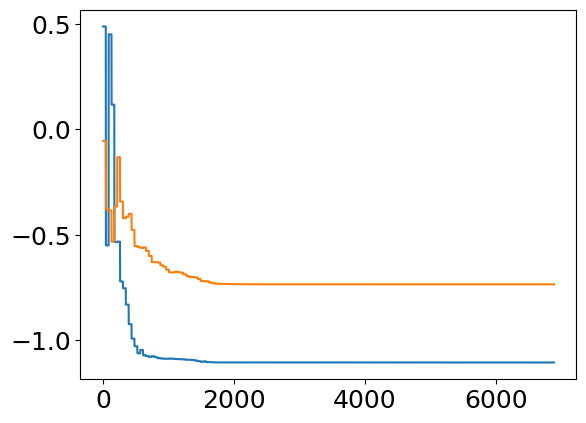

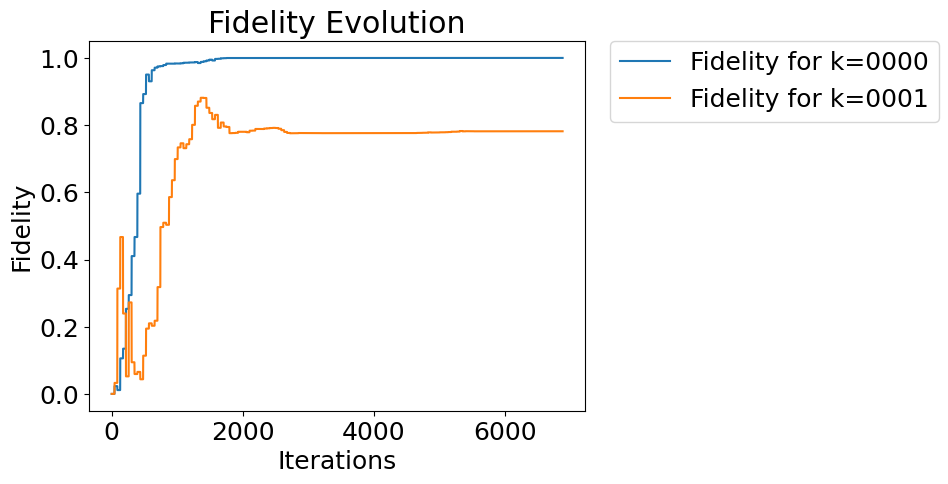

In [26]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from numpy import binary_repr
from qat.qpus import get_default_qpu

qpu = get_default_qpu()
method = "BFGS"



energy_lists = {f"energy_circ_{i}": {method: []} for i in range(len(circuits_store))}
fidelity_lists = {f"fidelity_circ_{i}": {method: []} for i in range(len(circuits_store))}

def opt_funct(circuits, model, qpu, nqbits, energy_lists, fidelity_lists, weight):
    def input_funct(x):
        total_energy = 0
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            result = qpu.submit(bound_circ.to_job(observable=model))
            energy = result.value
            energy_lists[f"energy_circ_{i}"][method].append(energy)

            # Calculate fidelity
            fidelity = fun_fidelity(bound_circ, eigenvecToT[i], nqbits)
            fidelity_lists[f"fidelity_circ_{i}"][method].append(fidelity)
            #print(fidelity)

            total_energy += weight[i] * energy
        return total_energy

    def callback(x):
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            result = qpu.submit(bound_circ.to_job(observable=model))
            energy = result.value
            energy_lists[f"energy_circ_{i}"][method].append(energy)

            # Calculate fidelity
            fidelity = fun_fidelity(bound_circ, eigenvecToT[i], nqbits)
            fidelity_lists[f"fidelity_circ_{i}"][method].append(fidelity)

    return input_funct, callback

input_funct, callback = opt_funct(circuits_store, model, qpu, nqbits, energy_lists, fidelity_lists, weight)
options = {"disp": True, "maxiter": 500, "gtol": 1e-7}

Optimizer = scipy.optimize.minimize(input_funct, x0=init_theta_list, method=method, callback=callback, options=options)

# Plot energy
plt.rcParams["font.size"] = 18
all_energy_lists = []

for i in range(len(circuits_store)):
    energy_list = energy_lists[f"energy_circ_{i}"][method]
    all_energy_lists.append(energy_list)
    plt.plot(range(len(energy_list)), energy_list, label=f"Energy for k={binary_repr(k_lst[i]).zfill(4)}")

    # Print the final energy for each k
    final_energy = energy_list[-1]
    print(f"Final energy for k={binary_repr(k_lst[i]).zfill(4)}: {final_energy}")

# Plot fidelity
plt.figure()
all_fidelity_lists = []

for i in range(len(circuits_store)):
    fidelity_list = fidelity_lists[f"fidelity_circ_{i}"][method]
    all_fidelity_lists.append(fidelity_list)
    plt.plot(range(len(fidelity_list)), fidelity_list, label=f"Fidelity for k={binary_repr(k_lst[i]).zfill(4)}")

    # Print the final fidelity for each k
    final_fidelity = fidelity_list[-1]
    print(f"Final fidelity for k={binary_repr(k_lst[i]).zfill(4)}: {final_fidelity}")

plt.xlabel("Iterations")
plt.ylabel("Fidelity")
plt.title("Fidelity Evolution")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.show()
